# Notebook 
### Contribution Statement:

We, Frida(s206182), Cecilie(s214605), and Marie(s204052), collaborated and contributed equally to the project at hand.

Website: 

In [1]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import networkx.algorithms.community as nx_community
import re
import string
import networkx.algorithms.community as nx_comm
import netwulf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from collections import Counter

# Semantics analysis
%pip install textblob
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


## Table of contents

1. [Datachoice](#data-choice)
    * [What data did we choose?](#what-data)  
    * [Why is this data interesting?](#motivation) 
<br>
<br>

2. [Data collection and filtering](#data-processing)
    * [Collecting data with Harry Potter API](#API)
    * [Webscraping wikis](#webscraping)
    * [Initial filtering of the data](#initial-filtering)
        * [Removing inanimate and unidintified data](#remove-inanimate)
        * [Cleaning species attribute](#clean-spicies)
        * [Removing actor names](#remove-actor)
<br>
<br>

3. [Making the network](#make-network)
    * [insert the name](insert the link)
    * [insert the name](insert the link)
    * [insert the name](insert the link)
        * [insert the name](insert the link)
<br>
<br>
4. [Semantic analysis](#semantic-analysis)
    * [insert the name](insert the link)
    * [insert the name](insert the link)
        * [insert the name](insert the link)


# 1. Data choice <a id='data-choice'></a>

<a id='what-data'></a>
### What data did we choose? 



<a id='motivation'></a>
### Why is this data interesting 

<a id='data-processing'></a>
# 2. Data collection and filtering

<a id='unique-id'></a>
## Collecting data with Harry Potter API

In [ ]:
# API link
BASE_URL = "https://api.potterdb.com/"
VERSION = "v1/"
RESOURCE = "characters"

my_url = BASE_URL + VERSION + RESOURCE
print(my_url)
all_data = {}
counter = 0
for i in range(50):

    url = my_url + f"?page[number={i+1}]&page[size=100]"
    r = requests.get(url)
    data = r.json()["data"]

    for i in data:
        all_data[counter] = {}
        name = (i['attributes']['name'])
        all_data[counter]['Name'] = i['attributes']['name']
        all_data[counter]['Blood status'] = i['attributes']['blood_status']
        all_data[counter]['House'] = i['attributes']['house']
        all_data[counter]['Species'] = i['attributes']['species']
        all_data[counter]['Death time'] = i['attributes']['died']
        all_data[counter]['Alias'] = i['attributes']['alias_names']
        all_data[counter]['Wiki'] = i['attributes']['wiki']
        all_data[counter]['Gender'] = i['attributes']['gender']
        counter +=1
    
df_data = pd.DataFrame.from_dict(all_data, orient='index')

<a id='webscraping'></a>
## Webscrape text data and node links from wiki

In [114]:
# Function to webscrape Harry Potter wiki for text and links
def webscrapeWiki(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    content_div = soup.find('div', {'id': 'mw-content-text'})
    text = ""
    exclude_sections = ["Appearances"]
    exclude_links = ["Appearances"]

    for p in content_div.find_all('p'):
        section_heading = p.find_previous_sibling('h2')
        if section_heading and section_heading.find('span', {'class': 'mw-headline'}).text in exclude_sections:
            break
        elif p.find_parents('table'):
            continue
        text += p.get_text() + " "

    links = []
    for ul in content_div.find_all("ul"):
        section_heading = ul.find_previous_sibling('h2')
        if section_heading and section_heading.find('span', {'class': 'mw-headline'}).text in exclude_sections:
            break
        elif ul.find_parents('table'):
            continue
        for li in ul.find_all("li"):
            for a in li.find_all("a"):
                if a.find_parents('table'):
                    continue
                split = a['href'].split("/")
                if len(split)>1:
                    if split[1]=="wiki" and section_heading is not None and section_heading.find('span', {'class': 'mw-headline'}).text not in exclude_links:
                        links.append(split[2])
    
    infobox = soup.find('aside', {'class': 'portable-infobox'})
    if infobox:
        for a in infobox.find_all('a'):
            href = a.get('href')
            if href:
                split = href.split("/")
                if len(split)>1:
                    if split[1]=="wiki":
                        links.append(split[2])

    return text, links

df_data["Wiki text"], df_data["Character links"] = zip(*df_data["Wiki"].apply(webscrapeWiki))

In [209]:
df_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."


In [120]:
def wikiName(wikiURL):
    return wikiURL.split("/")[-1]

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

df_data["Wiki name"] = df_data["Wiki"].apply(wikiName)
df_data["Sum character links"] = df_data["Character links"].apply(Counter)
df_data["Sum character links"] = df_data["Sum character links"].apply(checkLinks,wikiNames=df_data["Wiki name"])

#Save dataframe
df_data.to_pickle("df_data_updated2")

<a id='initial-filtering'></a>
## Initial filtering of data

In [58]:
# Load dataframe:
df_data_loaded = pd.read_pickle("df_data_updated2")

<a id='remove-inanimate'></a>
### Removing unidentified data points and inanimate links

In [59]:
# Getting filtered data
# Removing names holding 'Unidentified'
def checkUnidentified(wikiName):
    check = "Unidentified"
    if len(wikiName)>len(check):
        if wikiName[:len(check)]==check:
            return True
    return False

# Checking if links are persons
def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks


def removeDegreeZeros(df):
    hasDegreeDict = {}
    # Check if each character has out-degree:
    for i in df.index:
        hasDegreeDict[df["Wiki name"][i]] = False
        if len(df["Sum character links"][i]):
            hasDegreeDict[df["Wiki name"][i]] = True
    
    # Look at all character in-degree references:
    for i in df.index:
        for n in df["Sum character links"][i]:
            hasDegreeDict[n] = True
    
    remove = [name for (name, degrStatus) in hasDegreeDict.items() if not degrStatus]
    df_degree = df.drop(df[df["Wiki name"].isin(remove)].index)
    return df_degree

len_data = len(df_data_loaded)

# Filter data after having some information of Blood status, house, species, death time or alias
filtered_data = df_data_loaded[~((df_data_loaded["Blood status"].isnull())&(df_data_loaded["House"].isnull())&(df_data_loaded["Species"].isnull())&(df_data_loaded["Death time"].isnull())&(df_data_loaded["Alias"].isnull()))]
filt_data1 = len(filtered_data)

# Filter unidentified people away
filtered_data = filtered_data[~filtered_data["Wiki name"].apply(checkUnidentified)]
filt_data2 = len(filtered_data)

# Filter based on species (removing groups)
filtered_data = filtered_data[~(filtered_data['Species']=='Humans')]
filt_data3 = len(filtered_data)

# Remove links to non-characters:
filtered_data["Sum character links"] = filtered_data["Sum character links"].apply(checkLinks,wikiNames=filtered_data["Wiki name"])
filt_data4 = len(filtered_data)

# Remove characters with no links out or in:
filtered_data = removeDegreeZeros(filtered_data)
filt_data5 = len(filtered_data)

print('First filter removes:', len_data-filt_data1, 'characters')
print('Second filter removes:', len_data-filt_data2, 'characters')
print('Fourth filter removes:', len_data-filt_data3, 'characters')
print('Fifth filter removes:', len_data-filt_data5, 'characters')


First filter removes: 91 characters
Second filter removes: 522 characters
Fourth filter removes: 578 characters
Fifth filter removes: 2310 characters


In [60]:
# Function for cleaning the house names (removing unnecessary information)
def cleanHouses(House):
    if House != None:
        strings = House.split(' ')
        if len(strings) == 1:
            return strings[0]
        if len(strings) != 1:
            if len(strings) > 2:
                return 'Unknown'
            if strings[-1][-1] == ')':
                return strings[0]
    if House == None:
        return 'Unknown'

# Applying filter
filtered_data['House'] = filtered_data['House'].apply(cleanHouses)

<a id='remove-actor'></a>
### Removing actor names


In [61]:
# Function that scrapes actor names from each HP movies wikipediapage and appends them to a list
def scrape_actors(url, actor_names):
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
        soup = BeautifulSoup(html_content, 'html.parser')
        cast_element = soup.find('table', class_='cast_list')
        if cast_element:
            for row in cast_element.find_all('tr'):
                actor_element = row.find('td', class_='primary_photo')
                if actor_element:
                    actor_name = actor_element.find('img').get('alt')
                    if actor_name not in actor_names:
                        actor_names.append(actor_name)
    return actor_names

actor_names = []

# The Philosopher's Stone
url = 'https://www.imdb.com/title/tt0241527/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Chamber of Secrets
url = 'https://www.imdb.com/title/tt0295297/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Prisoner of Azkaban
url = 'https://www.imdb.com/title/tt0304141/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Goblet of Fire
url = 'https://www.imdb.com/title/tt0330373/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Order of the Phoenix
url = 'https://www.imdb.com/title/tt0373889/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# Half-Blood Prince 
url = 'https://www.imdb.com/title/tt0417741/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Deathly Hallows – Part 1
url = 'https://www.imdb.com/title/tt0926084/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Deathly Hallows – Part 2
url = 'https://www.imdb.com/title/tt1201607/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)

# Cleaning 'name' column for actornames
mask = ~filtered_data['Name'].isin(actor_names)
filtered_data = filtered_data[mask]
filt3_data = len(filtered_data)

print('Third filter removes:', len_data-filt3_data, 'characters')

Third filter removes: 2313 characters


In [56]:
filtered_data.head(5)

,Name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
9,Aberforth Dumbledore,Half-blood,None,Human,None,[Ab],https://harrypotter.fandom.com/wiki/Aberforth_...,Male,\n\n\n\n\n\n\n\nAberforth Dumbledore\n\n\nBiog...,"[Charm, Aberforth_Dumbledore%27s_goat_charm, P...",Aberforth_Dumbledore,"{'Albus_Dumbledore': 2, 'Gellert_Grindelwald':..."
10,Abernathy,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abernathy,Male,\n\n\n\n\n\n\n\nAbernathy\n\n\nBiographical in...,"[Apparition, Lestrange_Mausoleum, Abernathy%27...",Abernathy,"{'Percival_Graves': 1, 'Peter_Pettigrew': 1, '..."
13,Abigail R. Cankus,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abigail_R....,Female,\n\nAbigail R. Cankus\n\n\nBiographical inform...,"[United_States_of_America, Human, Template:Ind...",Abigail_R._Cankus,{}
15,Able Spudmore,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Able_Spudmore,Male,\n\nAble Spudmore\n\n\nBiographical informatio...,"[1923, Human, Randolph_Spudmore, Spudmore_fami...",Able_Spudmore,{'Randolph_Spudmore': 1}
16,Abraham,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abraham,Male,"""Point me!""\n \n\n\n\n\n\n\n\nAbraham\n\n\nPhy...",[Harry_Potter_and_the_Philosopher%27s_Stone_(f...,Abraham,"{'Albus_Dumbledore': 1, 'Isaac': 1}"


<a id='make-network'></a>
# 3. Making the network

In [62]:
# making edgelist
wiki_names = list(filtered_data['Wiki name'])
character_links = filtered_data['Sum character links']
houses = list(filtered_data['House'])

# Initializing graph
G = nx.MultiDiGraph()
# Adding group according to house attribute
for i in range(len(wiki_names)):
        G.add_node(wiki_names[i], group = houses[i])
print(G)

MultiDiGraph with 1751 nodes and 0 edges


In [63]:
# Making weighted edgelist
edges = []
for j in filtered_data.index:
    name = filtered_data['Wiki name'][j]
    links = filtered_data['Sum character links'][j]
    for key, val in links.items():
        edges.append(((name, key, val)))

In [64]:
# Adding edgelist to graph
G.add_weighted_edges_from(edges)
print(G)

MultiDiGraph with 1752 nodes and 7875 edges


In [65]:
# Remove nodes with no edges
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
print(f"{len(remove)} nodes with degree 0 were removed.") # Should be 0 as they are already removed
print(G)

G.remove_node('Jamie_Wolpert_(in-universe)') # removing node, that is added when graph is made, but not in original dataset

0 nodes with degree 0 were removed.
MultiDiGraph with 1752 nodes and 7875 edges


In [66]:
# Interactive visualization of graph (with group attribute according to 'house')
netwulf.interactive.visualize(G)

(None, None)

### Investigating communities

In [41]:
# Finding communities from splitting graph by 'House' attribute
import networkx.algorithms.community as nx_comm
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)
    
print('The different houses are:', houses_types)

houses_com = []
for i in houses_types:
    houses_com.append({x for x,y in G.nodes(data=True) if y['group']==i})

# computing modularity of 'house' split
house_mod = nx_comm.modularity(G, houses_com)
print('The modularity for the "house" split is: ' + str(house_mod))
no_comm = len(houses_com)
print('The number of "house" communities is ' + str(no_comm))
size_comm = []
for i in range(no_comm):
    size_comm.append(len(houses_com[i]))

The different houses are: ['Unknown', 'Hufflepuff', 'Slytherin', 'Ravenclaw', 'Gryffindor', 'Thunderbird', 'Pukwudgie', 'Wampus']
The modularity for the "house" split is: 0.13408011320520336
The number of "house" communities is 8


Text(0, 0.5, 'Count')

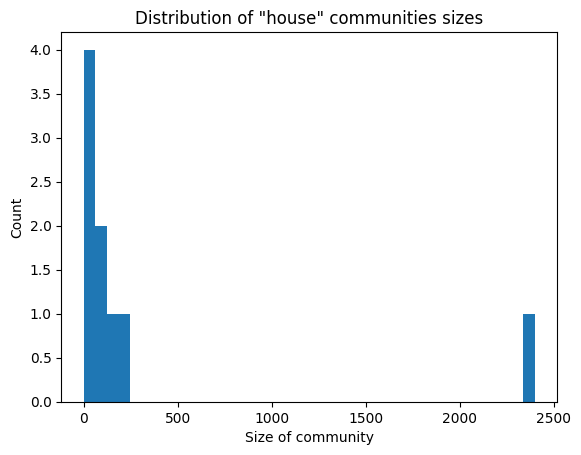

In [13]:
# Plotting distribution of sizes of 'house' communities
bins = np.linspace(min(size_comm), max(size_comm), 40)
hist, edges = np.histogram(size_comm, bins=bins)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of "house" communities sizes')
ax.set_xlabel('Size of community')
ax.set_ylabel('Count')

In [42]:
# Finding louvain communities
louv_comm = nx_comm.louvain_communities(G)

modularity_louv = nx_comm.modularity(G, louv_comm)
print('The modularity of Louvain algorithm is ' + str(modularity_louv))

no_comm = len(louv_comm)
print('The number of Louvain communities is ' + str(no_comm))

size_comm = []
for i in range(no_comm):
    size_comm.append(len(louv_comm[i]))

KeyboardInterrupt: 

Text(0, 0.5, 'Count')

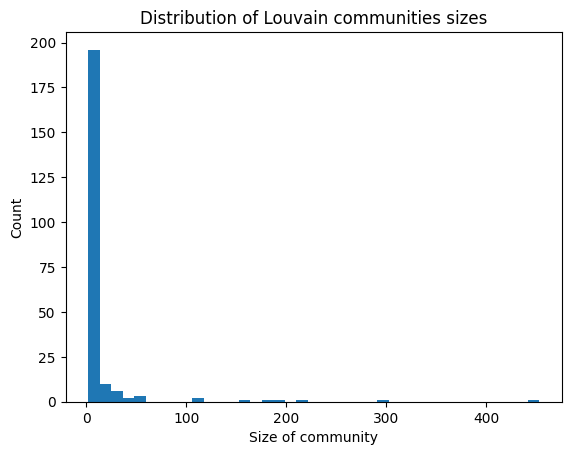

In [15]:
# Plotting distribution of comminuty sizes
bins = np.linspace(min(size_comm), max(size_comm), 40)
hist, edges = np.histogram(size_comm, bins=bins)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of Louvain communities sizes')
ax.set_xlabel('Size of community')
ax.set_ylabel('Count')
#ax.set_ylim(0,20)

## Visualizations

In [67]:
# Top 10 species
top_species = pd.DataFrame(filtered_data['Species'].value_counts().head(10))
top_species

,Species
Human,1518
"Human (formerly), Ghost",13
Goblin,10
House-elf,9
Giant,9
Cat,8
Bowtruckle,7
Centaur,6
Owl,6
Hippogriff,5


In [68]:
print('Number of unknown houses: ', len(filtered_data[filtered_data['House']=='Unknown']))
# Removing unknown houses
filtered_data = filtered_data[~(filtered_data['House']=='Unknown')]
# Getting data ready for plotting in a histogram
houses = filtered_data['House']
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)

dict = {}
for i in range(len(houses_types)):
    dict[i] = houses_types[i]

keys = list(dict.keys())
values = list(dict.values())

houses_int = []
for i in houses:
    for j in range(len(values)):
        if i == values[j]:
            houses_int.append(keys[j])

dict_len = []
for i in range(len(houses_types)):
    dict_len.append(len(filtered_data[filtered_data['House']==houses_types[i]]))

len_houses = pd.DataFrame()
len_houses['House'] = dict.values()
len_houses['Count'] = dict_len

Number of unknown houses:  1398


In [71]:
import plotly.express as px
# Plotting the distribution of house sizes
fig = px.bar(len_houses, x='House', y='Count', title="Count of members in each house", width=800, height=400)
fig.update_traces(width=0.8, marker_color=[('#ffc500'), ('#1a472a'), ('#0a5ea8'), ('#7f0909'), ('#8A8C8A'), ('#8A8C8A'),('#8A8C8A')], opacity=0.75)
fig.update_xaxes(griddash = 'solid')
fig.update_layout(title_x=0.5)
fig.show()

# Save figure as png
import os
if not os.path.exists("images"):
    os.mkdir("images")
fig.write_image("houses_count.png")

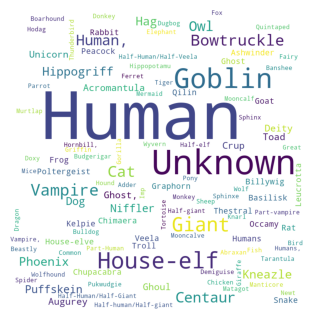

In [26]:
# Define a function to generate wordcloud
def generate_freq_wordcloud(data):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10)
    wordcloud.generate_from_frequencies(frequencies = data)
    plt.figure(figsize = (3,3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

generate_freq_wordcloud(species_freq)

In [74]:
# Finding top 10 nodes (characters) with highest in-degree and out-degree
in_degrees = {}
for i in G.in_degree:
    new_name=i[0].replace('_', ' ')
    in_degrees[new_name] = i[1]

out_degrees = {}
for i in G.out_degree:
    new_name=i[0].replace('_', ' ')
    out_degrees[new_name] = i[1]

max_in_deg = sorted(in_degrees, key=in_degrees.get, reverse=True)[:10]
max_out_deg = sorted(out_degrees, key=out_degrees.get, reverse=True)[:10]

in_df = pd.DataFrame(sorted(in_degrees.values(), reverse=True)[:10],max_in_deg,columns=['In-degree'])
out_df = a = pd.DataFrame(sorted(out_degrees.values(), reverse=True)[:10],max_out_deg,columns=['Out-degree'])

In [77]:
in_df

,In-degree
Harry Potter,210
Tom Riddle,187
Albus Dumbledore,111
Ronald Weasley,94
Hermione Granger,90
Sirius Black,67
Ginevra Weasley,65
Severus Snape,65
Arthur Weasley,62
Draco Malfoy,62


In [78]:
out_df

,Out-degree
Harry Potter,92
Albus Dumbledore,73
Jacob's sibling,62
Ronald Weasley,60
Hermione Granger,59
Arthur Weasley,49
Bellatrix Lestrange,48
Ginevra Weasley,48
Cedrella Black,45
Tom Riddle,43


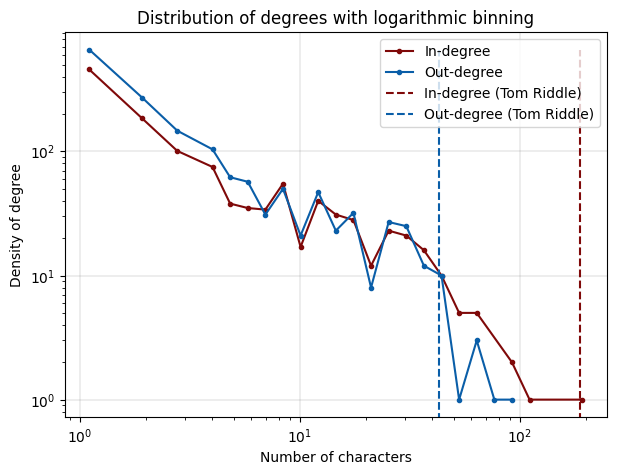

In [80]:
# Using matplotlib to plot the distribution of in-degrees and out-degrees
in_degrees = [degree for character, degree in G.in_degree()]
out_degrees = [degree for character, degree in G.out_degree()]

bins = np.logspace(0, np.log10(max(in_degrees)),30)
hist, edges = np.histogram(list(in_degrees), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='In-degree', color=('#7f0909'))
hist, edges = np.histogram(list(out_degrees), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
ax.plot(xx, yy, marker='.', label='Out-degree', color=('#0a5ea8'))

ax.set_xlabel('Number of characters')
ax.set_ylabel('Density of degree')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of degrees with logarithmic binning")
#ax.vlines(max(in_degrees),  0, max(yy), ls="--", colors='black', label='In-degree (Harry Potter)')
#ax.vlines(max(out_degrees),  0, max(yy), ls="--", colors='grey', label='Out-degree (Harry Potter)')
#ax.vlines(60,  0, max(yy), ls="--", colors='royalblue', label='In-degree (Ronald Weasley)')
#ax.vlines(28,  0, max(yy), ls="--", colors='lightblue', label='Out-degree (Ronald Weasley)')
ax.vlines(187,  0, max(yy), ls="--", colors=('#7f0909'), label='In-degree (Tom Riddle)')
ax.vlines(43,  0, max(yy), ls="--", colors=('#0a5ea8'), label='Out-degree (Tom Riddle)')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('degree_distribution_network.png', dpi=300)
plt.show()

/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_36929/608444523.py:9: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.



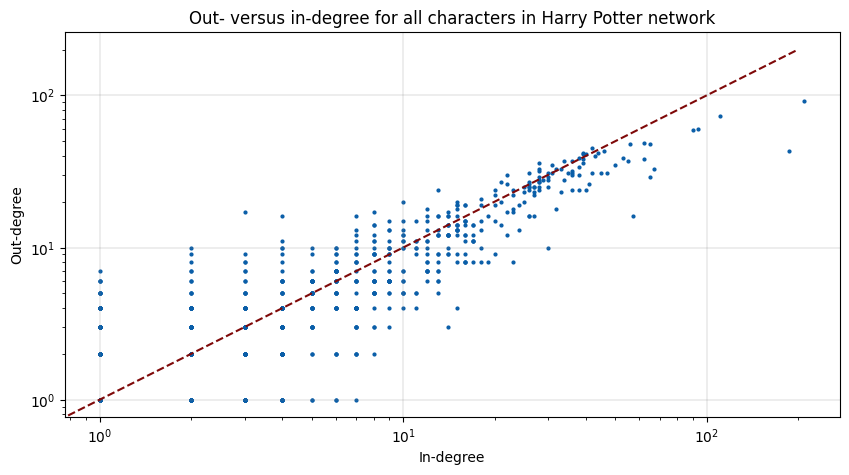

In [86]:
# Plotting in-degree vs out-degree (finding an relationship)
in_degrees = [degree for character, degree in G.in_degree()]
out_degrees = [degree for character, degree in G.out_degree()]

fig, ax = plt.subplots(figsize=(10,5) ,dpi=100)
ax.scatter(in_degrees, out_degrees, c=('#0a5ea8'), s=4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot([0, 10, 50, 100, 150, 175, 200], [0, 10, 50, 100, 150, 175, 200], "r--", color=('#7f0909'))
ax.set_xlabel('In-degree')
ax.set_ylabel('Out-degree')
ax.set_title('Out- versus in-degree for all characters in Harry Potter network')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('in_out_scatter.png', dpi=300)

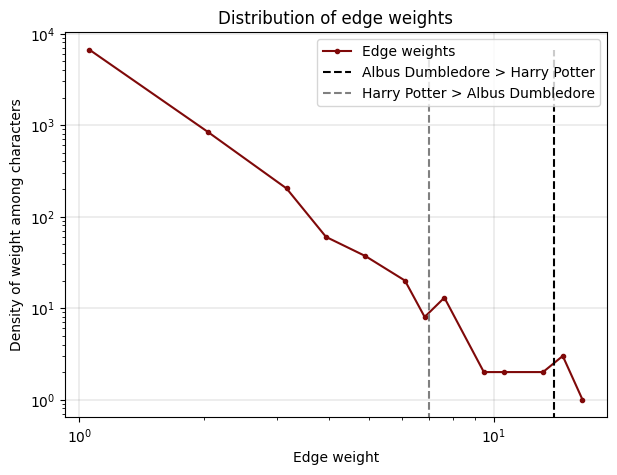

In [87]:
# Looking at the distribution of edge weights
all_weights = []
for i in list(G.edges(data=True)):
    w = list(i[2].values())
    all_weights.append(w[0])

bins = np.logspace(0, np.log10(max(all_weights)),30)
hist, edges = np.histogram(list(all_weights), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Edge weights', color=('#7f0909'))

ax.set_xlabel('Edge weight')
ax.set_ylabel('Density of weight among characters')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of edge weights")
ax.vlines(14,  0, max(yy), ls="--", colors='black', label='Albus Dumbledore > Harry Potter')
ax.vlines(7,  0, max(yy), ls="--", colors='grey', label='Harry Potter > Albus Dumbledore')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('edge_weight_distribution_network.png', dpi=300)
plt.show()

## Statistics

In [88]:
import scipy.stats as stats
# find mean, median, mode, min, max of both in and out degrees of Harry Potter network and random network
def findStats(G):
    min_in = np.min([d for n, d in G.in_degree()])
    min_out = np.min([d for n, d in G.out_degree()])
    print('Minimum of in-degree: ', min_in, ', and out-degree:', min_out)
    
    max_in = np.max([d for n, d in G.in_degree()])
    max_out = np.max([d for n, d in G.out_degree()])
    print('Maximum of in-degree: ', max_in, ', and out-degree:', max_out)
    
    mean_in = np.mean([d for n, d in G.in_degree()])
    mean_out = np.mean([d for n, d in G.out_degree()])
    print('Mean of in-degree: ', mean_in, ', and out-degree:', mean_out)
    
    median_in = np.median([d for n, d in G.in_degree()])
    median_out = np.median([d for n, d in G.out_degree()])
    print('Median of in-degree:', median_in,', and out-degree:', median_out)
    
    mode_in = stats.mode([d for n, d in G.in_degree()])
    mode_out = stats.mode([d for n, d in G.out_degree()])
    print('Mode of in-degree:', mode_in.mode,', and out-degree:', mode_out.mode)

In [89]:
# Harry Potter network
findStats(G)

Minimum of in-degree:  0 , and out-degree: 0
Maximum of in-degree:  210 , and out-degree: 92
Mean of in-degree:  4.496858937749857 , and out-degree: 4.496858937749857
Median of in-degree: 1.0 , and out-degree: 2.0
Mode of in-degree: [0] , and out-degree: [1]


/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_36929/1206058466.py:20: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_36929/1206058466.py:21: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



<a id='semantic-analysis'></a>
# 4. Semantic analysis of communities/houses

<a id='tokenize'></a>
## Tokenize

In [12]:
# Function to tokenize text
def tokenize_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token != 'none' and token != 'nan']
    return tokens

# Add column 'tokens' to df
filtered_data['tokens'] = filtered_data['Wiki text'].apply(tokenize_text) 

In [40]:
def compute_difference(row):
    return len(row["Wiki text"]) - len(row["tokens"])

filtered_data["length_difference"] = filtered_data.apply(compute_difference, axis=1)

average_wiki_length = filtered_data["Wiki text"].str.len().mean()
print(f"Average length of 'Wiki text': {average_wiki_length:.2f}")
average_tokens_length = filtered_data["tokens"].str.len().mean()
print(f"Average length of 'tokens': {average_tokens_length:.2f}")
average_difference = filtered_data["length_difference"].mean()
print(f"Average difference: {average_difference:.2f}")

Average length of 'Wiki text': 2900.55
Average length of 'tokens': 273.77
Average difference: 2626.77


We see that tokenizing the text drastically reduced the amount of words in each charecters wikipedia text. This makes sense, since Wikipedia articles often are written in a very formal style and aim to provide comprehensive and neutral information on a particular topic. As a result, they often contain a lot of common and generic words known as stopwords. By tokenizing the text we also remove things such as punctuation, numbers, and special characters, which also plays a part in the reduction.

In [13]:
house_documents = {}

for house in filtered_data['House'].unique():
    if house is None or house == "None":
        continue
    house_df = filtered_data[filtered_data['House'] == house]
    house_document = ' '.join(house_df['tokens'].explode().tolist())
    house_documents[house] = house_document

# Print the names of the house documents
print("Names of house documents:")
for house in house_documents:
    print(house)
    
# Count the number of house documents
num_houses = len(house_documents)
print("Number of house documents:", num_houses)

Names of house documents:
Unknown
Gryffindor
Slytherin
Hufflepuff
Ravenclaw
Thunderbird
Pukwudgie
Wampus
Number of house documents: 8


In [ ]:
### VERY LONG OUTPUT - no need to run cell,
# Just to check specific house document output
selected_house = "Gryffindor" 

if selected_house in house_documents:
    print(f"House: {selected_house}\nDocument: {house_documents[selected_house]}\n")
else:
    print(f"No document found for the house '{selected_house}'.\n")

In [17]:
house_colors = {
    "Gryffindor": "#7F0909",
    "Hufflepuff": "#FFC500",
    "Ravenclaw": "#0A5EA8",
    "Slytherin": "#1A472A"
}

def generate_wordcloud_tf_idf(tfidf_scores):
    for house, tfidf in tfidf_scores.items():
        data = dict(tfidf)
        color = house_colors.get(house, 'white')
        wordcloud = WordCloud(width=800, height=800, background_color=color,
                              min_font_size=10, colormap='viridis')
        wordcloud.generate_from_frequencies(frequencies=data)
        plt.figure(figsize=(3, 3), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(house) #Add house name title to tell them appart even if not apparent
        plt.tight_layout(pad=0)
        plt.show()


/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Unknown :
information 0.48314112528479564
harry 0.209703050697303
source 0.1795845463845436
hogwarts 0.17952525799022717
family 0.17377428374153098
species 0.16499960138269557
physical 0.1632209495532019
article 0.15106682871832852
gender 0.14413008658330326
human 0.14330004906287286
--------------------------


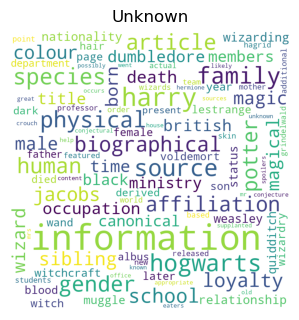

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Gryffindor :
harry 0.5680179983798772
hogwarts 0.2500383538937625
ron 0.22014898753776305
hermione 0.2080251883331207
school 0.17561503204348272
dumbledore 0.16313111999117774
gryffindor 0.1475262299257965
year 0.1445252895286078
potter 0.1410441986678689
weasley 0.13744307019124247
--------------------------


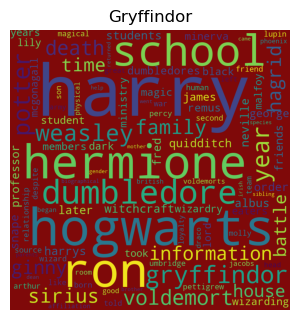

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Slytherin :
harry 0.3051730549201342
hogwarts 0.26220964951047815
voldemort 0.25578728478429247
school 0.2163672530166699
black 0.21149511425887385
slytherin 0.1968786979854857
snape 0.1939997069013335
death 0.17008193481760747
information 0.15768012707049026
draco 0.15745866621786317
--------------------------


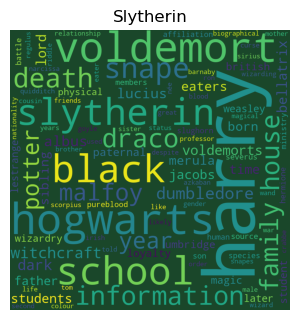

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Hufflepuff :
school 0.32344518648110526
hogwarts 0.32293901248035234
harry 0.24549439036515813
newt 0.240938824358382
hufflepuff 0.2399264763568762
information 0.21563012432073683
year 0.1943708162891149
witchcraft 0.16956829025222261
house 0.15438307022963552
jacobs 0.120469412179191
--------------------------


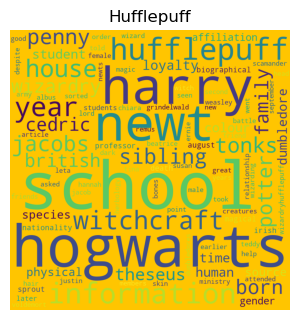

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Ravenclaw :
harry 0.35880213616709505
school 0.34713377401531964
hogwarts 0.32525559498074064
ravenclaw 0.2372566970861008
information 0.21003051873195808
year 0.19836215658018264
witchcraft 0.16238470661220833
potter 0.15168870797308084
luna 0.15120252621675687
house 0.12737962015688198
--------------------------


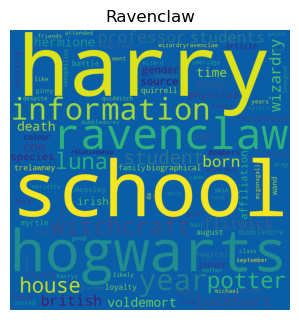

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Thunderbird :
tina 0.5682807272755662
newt 0.3806929143884861
department 0.16000136981545068
credence 0.14344950397247302
magical 0.14344950397247302
chadwick 0.12689763812949537
jacob 0.12138034951516949
family 0.11034577228651772
wand 0.11034577228651772
goldstein 0.10482848367219183
--------------------------


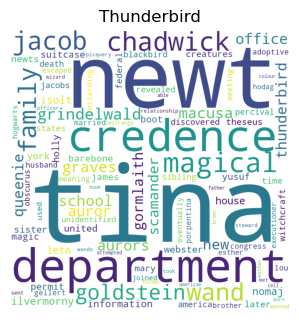

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Pukwudgie :
queenie 0.6329492247460683
jacob 0.39677414088559504
newt 0.2267280805060543
tina 0.20783407379721644
goldstein 0.15115205367070286
grindelwald 0.15115205367070286
sister 0.14170505031628394
department 0.13225804696186502
grindelwalds 0.08502303018977037
magical 0.08502303018977037
--------------------------


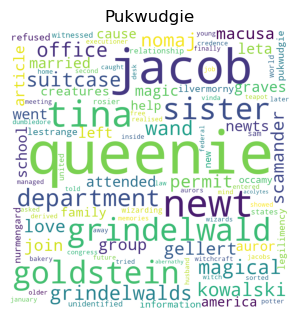

/Users/fridajorgensen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words and scores for Wampus :
webster 0.46267112855428977
gormlaith 0.29442708180727534
isolt 0.29442708180727534
boot 0.23133556427714488
chadwick 0.23133556427714488
family 0.21030505843376807
james 0.18927455259039128
school 0.16824404674701446
adoptive 0.14721354090363767
ilvermorny 0.14721354090363767
--------------------------


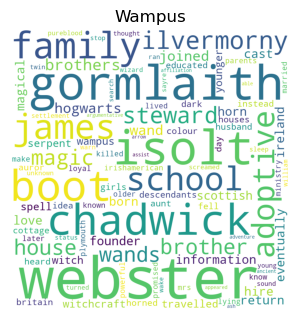

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the vectorizer with desired settings
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', use_idf=True)
tfidf = vectorizer.fit_transform(house_documents.values())

# Get the feature names and their scores for each house document
for house, document in house_documents.items():
    tfidf = vectorizer.fit_transform([document])
    words = vectorizer.get_feature_names()
    scores = tfidf.toarray()[0]
    # Top 100 words
    top100_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:100]
    top10_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:10]
    
    # Print the top 100 words and scores for the current house document
    print("Top 10 words and scores for", house, ":")
    for word, score in top10_scores:
        print(word, score)
    print("--------------------------")
    
    # Generate wordcloud for the current house
    generate_wordcloud_tf_idf({house: top100_scores})


<a id='sentiment-scores'></a>
## Sentiment scores? 

<a id='temporal'></a>
## Some temporal stuff

In [44]:
Script1 = pd.read_csv('Harry Potter and the Philosopher Stone script.csv', encoding='latin-1')
print(Script1)

     ID_number  scene      character_name  \
0            1      1    Albus Dumbledore   
1            2      1  Minerva McGonagall   
2            3      1    Albus Dumbledore   
3            4      1  Minerva McGonagall   
4            5      1    Albus Dumbledore   
..         ...    ...                 ...   
788        789     34       Rubeus Hagrid   
789        790     34        Harry Potter   
790        791     34       Rubeus Hagrid   
791        792     34    Hermione Granger   
792        793     34        Harry Potter   

                                              dialogue  
0    I should have known that you would be here, Pr...  
1    Good evening, Professor Dumbledore. Are the ru...  
2     I'm afraid so, Professor. The good, and the bad.  
3                                         And the boy?  
4                              Hagrid is bringing him.  
..                                                 ...  
788  Go on. On with you, on with you now. Oh, now l...  
789

/var/folders/6w/9xtjr5m971gb4jnrt_p0c0t80000gn/T/ipykernel_10752/2565192681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df['dialogue'].apply(get_sentiment_score)


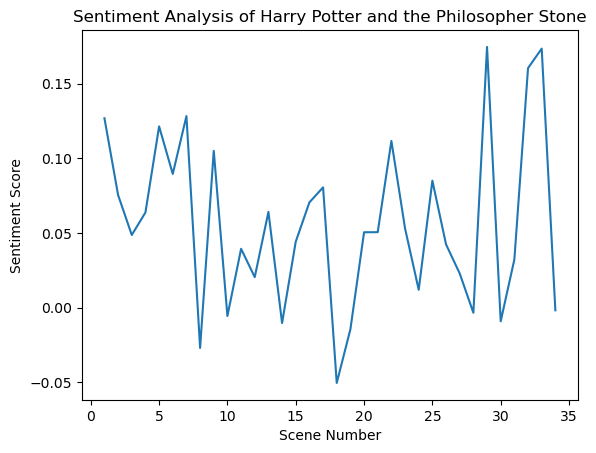

In [49]:
df = Script1[['dialogue', 'scene']]

# Function for sentiment score
def get_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment_score'] = df['dialogue'].apply(get_sentiment_score)
grouped = df.groupby('scene')['sentiment_score'].mean()

grouped.plot(kind='line', title='Sentiment Analysis of Harry Potter and the Philosopher Stone')
plt.xlabel('Scene Number')
plt.ylabel('Sentiment Score')
plt.show()


Det var så overhovedet ikke særlig interessant:(

Prøver med alle filmene nedenunder.

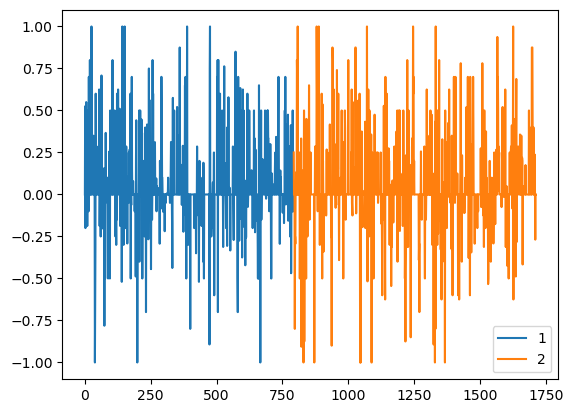

In [60]:
Script1 = pd.read_csv('hp_script1.csv', encoding='latin-1')
Script2 = pd.read_csv('hp_script2.csv', encoding='latin-1')
# Script3 = pd.read_csv('hp_script3.csv', encoding='latin-1')
# Script4 = pd.read_csv('hp_script4.csv', encoding='latin-1')
# Script5 = pd.read_csv('hp_script5.csv', encoding='latin-1')
# Script6 = pd.read_csv('hp_script6.csv', encoding='latin-1')
# Script7 = pd.read_csv('hp_script7.csv', encoding='latin-1')
# Script8 = pd.read_csv('hp_script8.csv', encoding='latin-1')

Script1['movie'] = 1
Script2['movie'] = 2
# Script3['movie'] = 3
# Script4['movie'] = 4
# Script5['movie'] = 5
# Script6['movie'] = 6
# Script7['movie'] = 7
# Script8['movie'] = 8

df = pd.concat([Script1, Script2], ignore_index=True)
# df = pd.concat([Script1, Script2, Script3, Script4, Script5, Script6, Script7, Script8], ignore_index=True)

# Column "sentiment" (score is set to zero before the loop)
df['sentiment'] = 0.0
for i, row in df.iterrows():
    text = row['dialogue']
    sentiment_score = TextBlob(text).sentiment.polarity
    df.at[i, 'sentiment'] = sentiment_score

df.groupby('movie')['sentiment'].plot(legend=True)
plt.show()



Stadig ikke sjovt :( Måske hvis man tager alle 8, men orker ikke nu 